In [1]:
from collections import OrderedDict
import re
import os
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

# NOTE: Update this path to point to YOUR own Google Drive folder
# (this repo assumes you have the project in Drive/MyDrive/limits-of-icl/src2)
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/limits-of-icl/src2'

!pip install wand munch

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names, plot_param_sweep, plot_experiment

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/limits-of-icl/src2


/content/drive/MyDrive/limits-of-icl/src2/plot_utils.py:43: SyntaxWarning: invalid escape sequence '\e'
  return "Local ($\ell_{window}$=5)"
/content/drive/MyDrive/limits-of-icl/src2/plot_utils.py:45: SyntaxWarning: invalid escape sequence '\e'
  return "Local ($\ell_{window}$=8)"
/content/drive/MyDrive/limits-of-icl/src2/plot_utils.py:47: SyntaxWarning: invalid escape sequence '\e'
  return "Local ($\ell_{window}$=15)"


In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

../models/linear_regression/nanogpt_local_100k_8/config.yaml
../models/linear_regression/nanogpt_local_100k_15/config.yaml
../models/linear_regression/nanogpt_mqa_100k/config.yaml
../models/linear_regression/nanogpt_rela_100k/config.yaml
../models/linear_regression/pretrained/config.yaml
../models/linear_regression/nanogpt_local_100k_5/config.yaml
../models/linear_regression/nanogpt_favor_100k/config.yaml
../models/linear_regression/nanogpt_softmax_100k/config.yaml
../models/linear_regression/dabb65f6-7e9b-4b32-b796-2a5af901efd2/config.yaml
../models/linear_regression/nanogpt_softmax_test/config.yaml
../models/linear_regression/nanogpt_rebased_100k/config.yaml


,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
4,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
8,dabb65f6-7e9b-4b32-b796-2a5af901efd2,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
6,nanogpt_favor_100k,linear_regression,nanogpt_favor_100k,,-1,-1,20,12,8,nanogpt_favor_100k
1,nanogpt_local_100k_15,linear_regression,nanogpt_local_100k_15,,-1,-1,20,12,8,nanogpt_local_100k_15
5,nanogpt_local_100k_5,linear_regression,nanogpt_local_100k_5,,-1,-1,20,12,8,nanogpt_local_100k_5
0,nanogpt_local_100k_8,linear_regression,nanogpt_local_100k_8,,-1,-1,20,12,8,nanogpt_local_100k_8
2,nanogpt_mqa_100k,linear_regression,nanogpt_mqa_100k,,-1,-1,20,12,8,nanogpt_mqa_100k
10,nanogpt_rebased_100k,linear_regression,nanogpt_rebased_100k,,-1,-1,20,12,8,nanogpt_rebased_100k
3,nanogpt_rela_100k,linear_regression,nanogpt_rela_100k,,-1,-1,20,12,8,nanogpt_rela_100k
7,nanogpt_softmax_100k,linear_regression,nanogpt_softmax_100k,,-1,-1,20,12,8,nanogpt_softmax_100k


In [5]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

# A list of models to compare - add more model run_ids here as needed
run_ids = ["nanogpt_local_100k_15", "nanogpt_local_100k_5", "nanogpt_mqa_100k", "nanogpt_softmax_100k", "nanogpt_rela_100k", "nanogpt_favor_100k", "nanogpt_rebased_100k"]
# run_ids = ["nanogpt_local_100k_5"]

recompute_metrics = True  # Set to True to force recomputation

# Load metrics from each model's metrics.json and combine them
results = {}
for run_id in run_ids:
    run_path = os.path.join(run_dir, task, run_id)
    metrics_path = os.path.join(run_path, "metrics.json")

    model_metrics = None

    # Try to load existing metrics.json if not forcing recompute
    if not recompute_metrics and os.path.exists(metrics_path):
        try:
            with open(metrics_path, "r") as f:
                model_metrics = json.load(f)
            print(f"Loaded cached metrics for {run_id}")
        except (json.JSONDecodeError, ValueError) as e:
            print(f"Warning: metrics.json for {run_id} is corrupted or empty. Recomputing...")
            model_metrics = None

    # If metrics don't exist, are corrupted, or recompute is forced, compute them
    if model_metrics is None:
        print(f"Computing metrics for {run_id}...")
        model_metrics = get_run_metrics(run_path, cache=not recompute_metrics)

    # Add this model's metrics to results, organizing by experiment type
    for experiment_name, model_results in model_metrics.items():
        if experiment_name not in results:
            results[experiment_name] = {}
        # Add this model's results under the run_id as the model name
        for model_name, metrics in model_results.items():
            # Use run_id as the model identifier to distinguish different models
            combined_name = f"{run_id}" if ("nanogpt" in model_name or "gpt2" in model_name) else model_name
            results[experiment_name][combined_name] = metrics

# Optionally save combined results for reference
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

print(f"\nLoaded metrics from {len(run_ids)} models")
print(f"Experiment types: {list(results.keys())}")

Computing metrics for nanogpt_local_100k_15...
../models/linear_regression/nanogpt_local_100k_15/config.yaml
number of parameters: 9.48M
odict_keys(['_read_in.weight', '_read_in.bias', '_backbone.transformer.wpe.weight', '_backbone.transformer.h.0.ln_1.weight', '_backbone.transformer.h.0.ln_1.bias', '_backbone.transformer.h.0.attn.c_attn.weight', '_backbone.transformer.h.0.attn.c_attn.bias', '_backbone.transformer.h.0.attn.c_proj.weight', '_backbone.transformer.h.0.attn.c_proj.bias', '_backbone.transformer.h.0.ln_2.weight', '_backbone.transformer.h.0.ln_2.bias', '_backbone.transformer.h.0.mlp.c_fc.weight', '_backbone.transformer.h.0.mlp.c_fc.bias', '_backbone.transformer.h.0.mlp.c_proj.weight', '_backbone.transformer.h.0.mlp.c_proj.bias', '_backbone.transformer.h.1.ln_1.weight', '_backbone.transformer.h.1.ln_1.bias', '_backbone.transformer.h.1.attn.c_attn.weight', '_backbone.transformer.h.1.attn.c_attn.bias', '_backbone.transformer.h.1.attn.c_proj.weight', '_backbone.transformer.h.1.at

100%|██████████| 190/190 [01:09<00:00,  2.75it/s]


{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [5.333540916442871], 'std': [12.889798164367676], 'bootstrap_low': [4.776524543762207], 'bootstrap_high': [6.007279396057129]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [0.4120582938194275], 'std': [1.8473191261291504], 'bootstrap_low': [0.33768942952156067], 'bootstrap_high': [0.5039082765579224]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [0.7805301547050476], 'std': [2.0102181434631348], 'bootstrap_low': [0.6897808313369751], 'bootstrap_high': [0.8721020817756653]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [1.8330347537994385], 'std': [4.447671413421631], 'bootstrap_low': [1.641200304031372], 'bootstrap_high': [2.043567419052124]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [2.823335

100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [17.260793685913086], 'std': [26.97433853149414], 'bootstrap_low': [15.970807075500488], 'bootstrap_high': [18.505599975585938]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [0.7647950053215027], 'std': [1.338106632232666], 'bootstrap_low': [0.7042943239212036], 'bootstrap_high': [0.825587272644043]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [2.2813684940338135], 'std': [3.782099485397339], 'bootstrap_low': [2.119960308074951], 'bootstrap_high': [2.465276002883911]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [5.362613201141357], 'std': [9.151557922363281], 'bootstrap_low': [4.969544410705566], 'bootstrap_high': [5.780754089355469]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8_attn=local_global': {'mean': [9.80125713348

100%|██████████| 190/190 [01:17<00:00,  2.44it/s]


{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=mqa': {'mean': [0.04149355739355087], 'std': [0.07362999022006989], 'bootstrap_low': [0.03852303698658943], 'bootstrap_high': [0.04493631049990654]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=mqa': {'mean': [0.009291017428040504], 'std': [0.01361355371773243], 'bootstrap_low': [0.008679923601448536], 'bootstrap_high': [0.00987672246992588]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=mqa': {'mean': [0.010462820529937744], 'std': [0.01641879603266716], 'bootstrap_low': [0.009734852239489555], 'bootstrap_high': [0.01120021939277649]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=mqa': {'mean': [0.015641437843441963], 'std': [0.026839952915906906], 'bootstrap_low': [0.014442403800785542], 'bootstrap_high': [0.01687866821885109]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8_attn=mqa': {'mean': [0.022547442466020584], 's

100%|██████████| 190/190 [01:06<00:00,  2.84it/s]


{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=softmax_causal': {'mean': [0.03516482561826706], 'std': [0.05341897904872894], 'bootstrap_low': [0.03274725005030632], 'bootstrap_high': [0.03764338046312332]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=softmax_causal': {'mean': [0.007614675909280777], 'std': [0.011440721340477467], 'bootstrap_low': [0.00711130490526557], 'bootstrap_high': [0.008136238902807236]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=softmax_causal': {'mean': [0.009650700725615025], 'std': [0.021911591291427612], 'bootstrap_low': [0.008714428171515465], 'bootstrap_high': [0.01064577978104353]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=softmax_causal': {'mean': [0.014275419525802135], 'std': [0.021532772108912468], 'bootstrap_low': [0.013329723849892616], 'bootstrap_high': [0.015307396650314331]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8

100%|██████████| 190/190 [01:19<00:00,  2.40it/s]


{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=rela': {'mean': [0.15769675374031067], 'std': [0.36540448665618896], 'bootstrap_low': [0.14088138937950134], 'bootstrap_high': [0.17511752247810364]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=rela': {'mean': [0.013112996704876423], 'std': [0.022805213928222656], 'bootstrap_low': [0.012148460373282433], 'bootstrap_high': [0.014194836840033531]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=rela': {'mean': [0.025973448529839516], 'std': [0.0478864423930645], 'bootstrap_low': [0.023850059136748314], 'bootstrap_high': [0.028361553326249123]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=rela': {'mean': [0.03957067057490349], 'std': [0.07182363420724869], 'bootstrap_low': [0.03621688857674599], 'bootstrap_high': [0.042780954390764236]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8_attn=rela': {'mean': [0.07028163224458694]

100%|██████████| 190/190 [02:18<00:00,  1.38it/s]


{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=favor': {'mean': [0.08263573795557022], 'std': [0.13561154901981354], 'bootstrap_low': [0.07608389109373093], 'bootstrap_high': [0.08892979472875595]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=favor': {'mean': [0.011838553473353386], 'std': [0.017961299046874046], 'bootstrap_low': [0.011062593199312687], 'bootstrap_high': [0.012679514475166798]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=favor': {'mean': [0.017682667821645737], 'std': [0.026706591248512268], 'bootstrap_low': [0.01651754043996334], 'bootstrap_high': [0.01900615356862545]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=favor': {'mean': [0.02520669996738434], 'std': [0.036832623183727264], 'bootstrap_low': [0.023591620847582817], 'bootstrap_high': [0.026944899931550026]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8_attn=favor': {'mean': [0.04175030812

100%|██████████| 190/190 [02:05<00:00,  1.51it/s]

{'standard': {'nanogpt_embd=256_layer=12_head=8_attn=rebased': {'mean': [0.08753829449415207], 'std': [0.1617424637079239], 'bootstrap_low': [0.08087500184774399], 'bootstrap_high': [0.09530478715896606]}}, 'scaled_query_scale=0.1': {'nanogpt_embd=256_layer=12_head=8_attn=rebased': {'mean': [0.01567445881664753], 'std': [0.027410592883825302], 'bootstrap_low': [0.01438075304031372], 'bootstrap_high': [0.01692579872906208]}}, 'scaled_query_scale=0.30000000000000004': {'nanogpt_embd=256_layer=12_head=8_attn=rebased': {'mean': [0.017341557890176773], 'std': [0.025355404242873192], 'bootstrap_low': [0.01616557501256466], 'bootstrap_high': [0.018528684973716736]}}, 'scaled_query_scale=0.5': {'nanogpt_embd=256_layer=12_head=8_attn=rebased': {'mean': [0.02799234166741371], 'std': [0.04468114674091339], 'bootstrap_low': [0.025867212563753128], 'bootstrap_high': [0.030259232968091965]}}, 'scaled_query_scale=0.7000000000000001': {'nanogpt_embd=256_layer=12_head=8_attn=rebased': {'mean': [0.04534

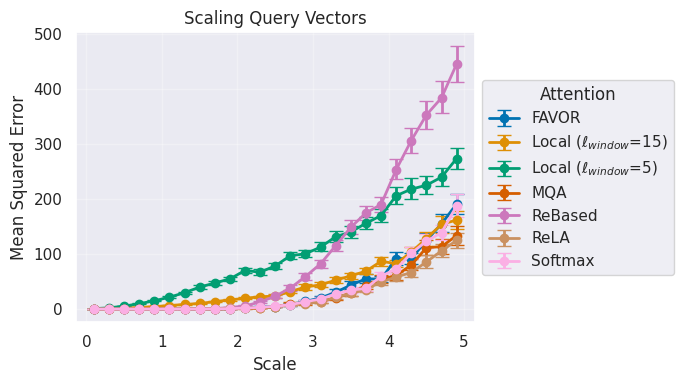

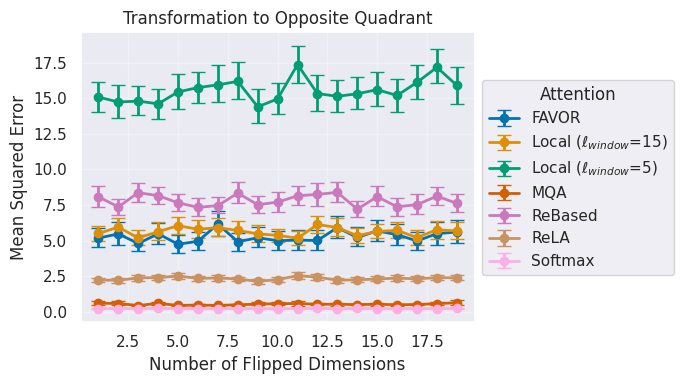

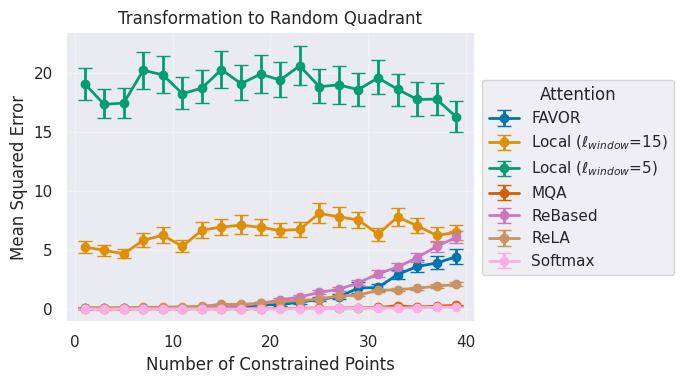

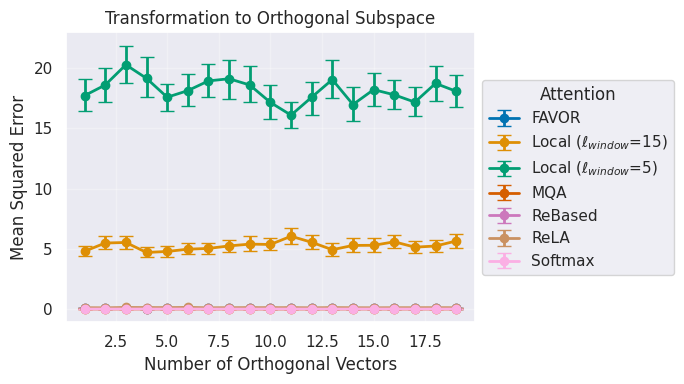

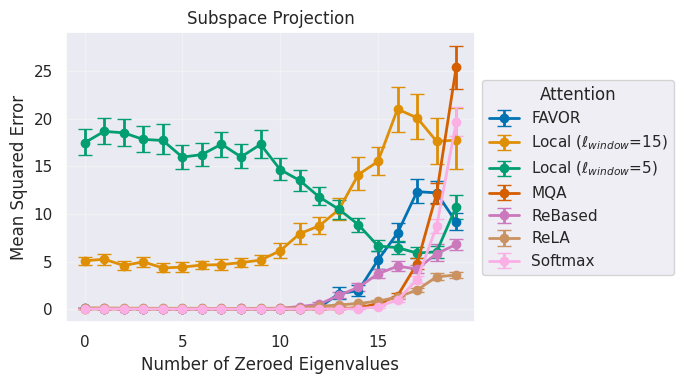

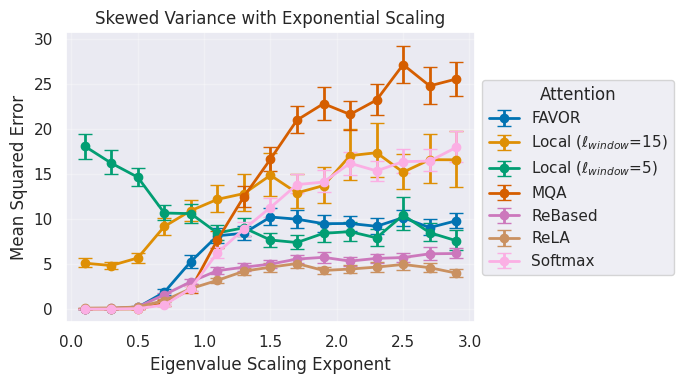

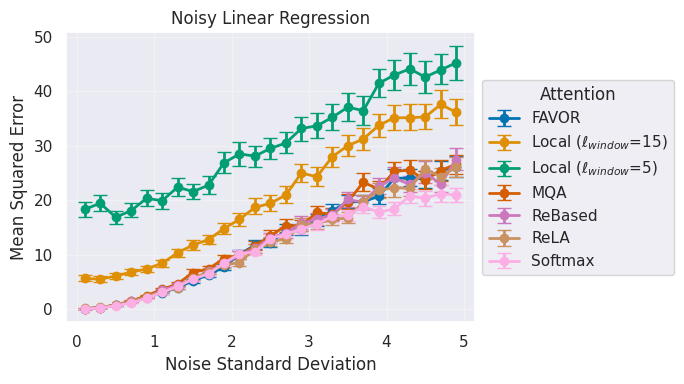

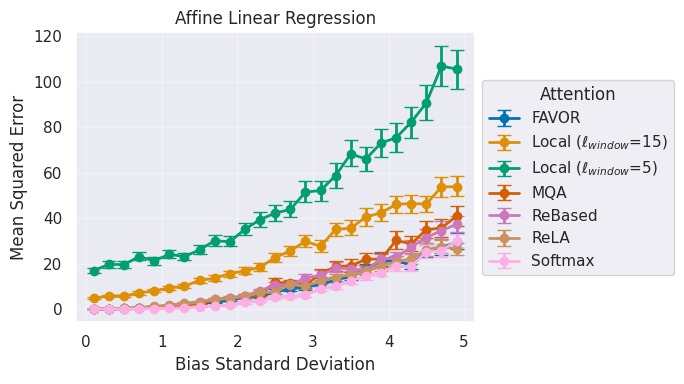

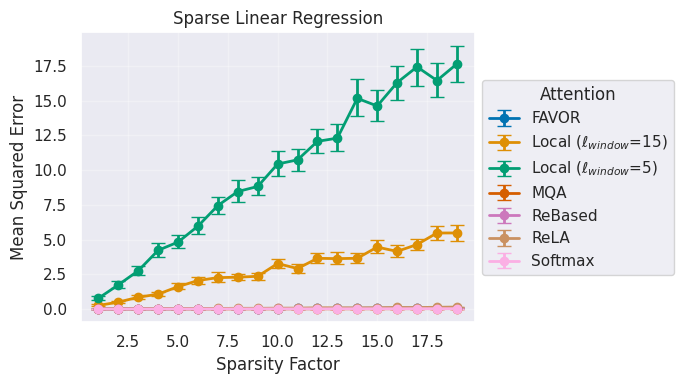

In [6]:
# Plot all parameter sweep experiments (comparing all models)
figs = plot_param_sweep(results)

for fig in figs:
    plt.show()